In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt
from models import create_model 
import pandas as pd

import yaml
import torch
from pipeline.walkforward import WFCVGenerator
from utils.paths import CONFIG_DIR, VOL_EXPERIMENTS_DIR, DATA_DIR, PRICE_EXPERIMENTS_DIR

from config.config_types import AppConfig


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import json


In [3]:

fold_num = 0
name = "exp_001_mlp_40_sliding"
name = "exp_010_cnn_40_sliding"
name = "exp_006_cnn_40"
name = "exp_012_cnn_40"
name = "exp_011_mlp_40"
name = "exp_013_mlp_504"
name = "exp_011_mlp_40"

name  = "exp_013_debug"
trial = "trial_20251104_171007" 

# -------- load config --------
base = f"{VOL_EXPERIMENTS_DIR}/{name}/{trial}/"
conifg_path = f"{base}config_snapshot.json"

with open(conifg_path, 'r') as f:
    cfg = json.load(f)

cfg = cfg["cfg"]

cfg = AppConfig.from_dict(cfg)

if cfg.data["df_master"] is not None:
    df_master_path =  cfg.data["df_master"]
    df_master = pd.read_parquet(f"{DATA_DIR}/{df_master_path}")
    #print(f"provided df master: {df_master_path}\n{df_master.head()}")
else:
    df_master = None

wf = WFCVGenerator(config=cfg.walkforward)


17:15:46 - WFCVGenerator - DEBUG - WFConfig(train=900d, val=300d, test=300d, lags=100, step=300, max_folds=None) (walkforward.py:27)
17:15:46 - WFCVGenerator - DEBUG - Loading data via preprocess() (walkforward.py:48)
17:15:48 - WFCVGenerator - DEBUG - Loaded df: shape=(3155297, 3) dtypes={'t': dtype('int16'), 'var': dtype('float64'), 'permno': Int64Dtype()} head=
 t      var  permno
 0 0.001527   10078
 1 0.001098   10078
 2 0.004587   10078 (walkforward.py:70)
17:15:48 - WFCVGenerator - DEBUG - Predicting var (walkforward.py:37)
17:15:48 - WFCVGenerator - DEBUG - self.df.columns: Index(['t', 'var', 'permno'], dtype='object') (walkforward.py:38)


In [4]:
results = pd.read_csv(f"{base}/results.csv")
results


,trial,fold,tr_loss,val_loss,test_loss,tr_mae,val_mae,test_mae,tr_directional_accuracy_pct,val_directional_accuracy_pct,test_directional_accuracy_pct,seconds,model_path
0,0,0,4.277103e-07,1.812719e-07,1.648179e-07,0.000354,0.000276,0.000263,99.387788,98.212615,97.837725,262.7629,/orcd/home/002/corte911/code/finNN_code/src/vo...


In [5]:
results.drop(columns="model_path").mean().apply(lambda x: round(x, 5))

trial                              0.00000
fold                               0.00000
tr_loss                            0.00000
val_loss                           0.00000
test_loss                          0.00000
tr_mae                             0.00035
val_mae                            0.00028
test_mae                           0.00026
tr_directional_accuracy_pct       99.38779
val_directional_accuracy_pct      98.21262
test_directional_accuracy_pct     97.83772
seconds                          262.76290
dtype: float64

In [6]:

test_data = {}
data = {}
for i, fold_data in enumerate(wf.folds()):
    X_test = fold_data[4]
    y_test = fold_data[5]

    test_data[i] = [X_test, y_test]
    data[i] = fold_data
    print(i)
    if i == fold_num:
        break


17:15:57 - WFCVGenerator - DEBUG - base:          feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0         0.001527   0.001098   0.004587   0.001987   0.001109   0.001777   
1         0.005466   0.005548   0.005260   0.004650   0.002337   0.002646   
2         0.001633   0.000877   0.001704   0.001076   0.000759   0.000168   
3         0.001556   0.000402   0.001299   0.000763   0.000339   0.000296   
4         0.000487   0.000866   0.000314   0.000401   0.000703   0.000348   
...            ...        ...        ...        ...        ...        ...   
3046922   0.000302   0.000166   0.000565   0.000506   0.000230   0.000698   
3046923   0.000611   0.000383   0.000436   0.000270   0.000370   0.000158   
3046924   0.000693   0.000206   0.000223   0.000356   0.000310   0.000070   
3046925   0.000205   0.000057   0.000127   0.000257   0.000224   0.000156   
3046926   0.000875   0.000339   0.000249   0.000769   0.000799   0.000651   

         feature_6  feature_7  fea

0


In [7]:


hparams = cfg.model.hparams
input_shape = (cfg.walkforward.lags,)
output_shape = cfg.walkforward.lookback+1

ckpt_path = f"{base}fold_{fold_num:03d}/model_best.pt"
checkpoint = torch.load(ckpt_path, map_location="cuda")




In [8]:
import math
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

sns.set_theme(style="darkgrid", context="talk")

def maybe_inverse(y, scaler):
    return y if scaler is None else scaler.inverse_transform(y.reshape(-1,1)).ravel()





def plot_split_dims(title, y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # Ensure 2D: (N,) -> (N,1)
    if y_true.ndim == 1:
        y_true = y_true.reshape(-1, 1)
    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1, 1)

    assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"
    N, K = y_true.shape

    # --- single-output: keep your original style ---
    if K == 1:
        yt = y_true[:, 0]
        yp = y_pred[:, 0]

        # fit + metrics
        reg = LinearRegression().fit(yt.reshape(-1,1), yp)
        slope, intercept = reg.coef_[0], reg.intercept_
        r2 = r2_score(yt, yp)
        rmse = np.sqrt(mean_squared_error(yt, yp))

        # min/max limits (with small padding)
        low = min(yt.min(), yp.min())
        high = max(yt.max(), yp.max())
        #vals = np.concatenate([yt.ravel(), yp.ravel()])
        #low, high = np.percentile(vals, [5, 95])
        pad = 0.02 * (high - low)
        low -= pad; high += pad

        x_line = np.linspace(low, high, 200)
        y_line = reg.predict(x_line.reshape(-1,1))

        # scatter + fit
        plt.figure(figsize=(10,8))
        plt.scatter(yt, yp, s=8, alpha=0.5, edgecolors="none")
        plt.plot([low, high], [low, high], 'k--', lw=1, label="45° line")
        plt.plot(x_line, y_line, 'r-', lw=2, label=f'Fit: y={slope:.3f}x+{intercept:.3f}')
        plt.title(f"{title} — R²={r2:.5f}, RMSE={rmse:.5g}")
        plt.xlabel("True"); plt.ylabel("Predicted")
        plt.xlim(low, high); plt.ylim(low, high)
        plt.legend(); plt.tight_layout(); plt.show()

        # KDEs
        plt.figure(figsize=(8,5))
        sns.kdeplot(yt, fill=True, alpha=0.5, label="True", linewidth=2)
        sns.kdeplot(yp, fill=True, alpha=0.5, label="Predicted", linewidth=2)
        plt.title(f"Distributions — {title}")
        plt.xlabel("Value"); plt.ylabel("Density")
        plt.xlim(low, high)
        plt.legend(); plt.tight_layout(); plt.show()
        return

    # --- multi-output: grid of subplots (one per dimension) ---
    ncols = min(3, K)                     # up to 3 columns wide
    nrows = math.ceil(K / ncols)

    fig_scatter, axes_s = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows), squeeze=False)

    for j in range(K):
        r, c = divmod(j, ncols)
        ax = axes_s[r, c]

        yt = y_true[:, j]
        yp = y_pred[:, j]
        perc = (yt > yp).mean() * 100
        print(f'percentage: {perc:.4f}')

        reg = LinearRegression().fit(yt.reshape(-1,1), yp)
        slope, intercept = reg.coef_[0], reg.intercept_
        r2 = r2_score(yt, yp)
        rmse = np.sqrt(mean_squared_error(yt, yp))

        low = min(yt.min(), yp.min())
        high = max(yt.max(), yp.max())
        #vals = np.concatenate([yt.ravel(), yp.ravel()])
        #low, high = np.percentile(vals, [2.5, 97.5])

        pad = 0.02 * (high - low)
        low -= pad; high += pad

        x_line = np.linspace(low, high, 200)
        y_line = reg.predict(x_line.reshape(-1,1))

        ax.scatter(yt, yp, s=8, alpha=0.5, edgecolors="none")
        ax.plot([low, high], [low, high], 'k--', lw=1, label="45° line")
        ax.plot(x_line, y_line, 'r-', lw=2, label=f'Fit: y={slope:.3f}x+{intercept:.3f}')
        ax.set_title(f"Dim {j} — R²={r2:.5f}, RMSE={rmse:.5g}")
        ax.set_xlabel("True"); ax.set_ylabel("Predicted")
        ax.set_xlim(low, high); ax.set_ylim(low, high)
        ax.legend(loc="best")

    # Hide any unused axes
    for j in range(K, nrows*ncols):
        r, c = divmod(j, ncols)
        fig_scatter.delaxes(axes_s[r, c])

    fig_scatter.suptitle(f"{title} — Scatter & Fit per Dimension", y=0.995, fontsize=14)
    fig_scatter.tight_layout()
    plt.show()

    # --- optional: KDE grid per dimension ---
    fig_kde, axes_k = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows), squeeze=False)
    for j in range(K):
        r, c = divmod(j, ncols)
        ax = axes_k[r, c]
        yt = y_true[:, j]; yp = y_pred[:, j]
        low = min(yt.min(), yp.min()); high = max(yt.max(), yp.max())
        pad = 0.02 * (high - low); low -= pad; high += pad

        sns.kdeplot(yt, fill=True, alpha=0.5, label="True", linewidth=2, ax=ax)
        sns.kdeplot(yp, fill=True, alpha=0.5, label="Predicted", linewidth=2, ax=ax)
        ax.set_title(f"KDE — Dim {j}")
        ax.set_xlabel("Value"); ax.set_ylabel("Density")
        ax.set_xlim(low, high)
        ax.legend(loc="best")

    for j in range(K, nrows*ncols):
        r, c = divmod(j, ncols)
        fig_kde.delaxes(axes_k[r, c])

    fig_kde.suptitle(f"Distributions — {title}", y=0.995, fontsize=14)
    fig_kde.tight_layout()
    plt.show()

def _infer_lstm_input_size_from_ckpt(state_dict: dict) -> int | None:
    # look for first LSTM weight_ih
    for k, v in state_dict.items():
        if k.endswith("lstm_layers.0.weight_ih_l0") or ("lstm_layers.0.weight_ih_l0" in k):
            # shape is [4*H, input_size]
            return int(v.shape[1])
    # legacy single-module naming (if any)
    for k, v in state_dict.items():
        if k.endswith("lstm.weight_ih_l0") or ("lstm.weight_ih_l0" in k):
            return int(v.shape[1])
    return None

def _make_input_shape_for_eval(cfg, X_sample: torch.Tensor | np.ndarray, state_dict: dict):
    name = cfg.model.name.lower()
    # infer T and (optional) D from the data
    if isinstance(X_sample, np.ndarray):
        shape = X_sample.shape
    else:
        shape = tuple(X_sample.shape)
    # shape is typically (N, T) or (N, T, D)
    if len(shape) == 2:
        _, T = shape
        D_data = 1
    elif len(shape) == 3:
        _, T, D_data = shape
    else:
        raise ValueError(f"Unexpected batch shape for X: {shape}")

    if name == "lstm":
        D_ckpt = _infer_lstm_input_size_from_ckpt(state_dict)
        D = D_ckpt if D_ckpt is not None else D_data  # prefer ckpt
        return (T, D)
    elif name == "simplecnn":
        # your CNN expects (C, L) with C=1
        return (1, T)
    elif name == "mlp":
        # your MLP code expects (T,) as before (flattened window)
        return (T,)
    else:
        raise ValueError(f"Unknown model name: {cfg.model.name}")

@torch.inference_mode()
def _predict_batched(model, X, device="cuda", bs=8192):
    preds = []
    for i in range(0, len(X), bs):
        xb = torch.as_tensor(X[i:i+bs], dtype=torch.float32, device=device)
        pb = model(xb).detach().cpu()
        preds.append(pb)
    return torch.cat(preds, dim=0).numpy()

def eval_and_plot_simple(cfg, input_shape, output_shape, ckpt, datasets, device="cuda"):
    Xtr, ytr, Xv, yv, Xte, yte = datasets

    # strip compile prefix if present
    state_dict = {k.replace("_orig_mod.", ""): v for k, v in ckpt["model_state"].items()}

    # build the **correct** input_shape for this checkpoint + data
    input_shape = _make_input_shape_for_eval(cfg, Xtr, state_dict)

    # (optional) infer output_dim from head if you want to be robust
    # otherwise keep your existing output_shape
    # try to find last linear in head
    out_dim = None
    for k, v in state_dict.items():
        if k.startswith("head.") and k.endswith(".weight"):
            if out_dim is None or v.shape[0] < out_dim:
                out_dim = int(v.shape[0])
    if out_dim is not None:
        output_shape = out_dim

    # rebuild & load model
    model = create_model(cfg.model, input_shape, output_shape)
    model.load_state_dict(state_dict, strict=True)
    model.to(device).eval()

    # predictions (batched to avoid OOM)
    yhat_tr = _predict_batched(model, Xtr, device=device, bs=8192)
    yhat_v  = _predict_batched(model, Xv,  device=device, bs=8192)
    yhat_te = _predict_batched(model, Xte, device=device, bs=8192)

    # numpy true arrays
    ytr = np.asarray(ytr, dtype=np.float32)
    yv  = np.asarray(yv,  dtype=np.float32)
    yte = np.asarray(yte, dtype=np.float32)

    print("Train", ytr.shape, yhat_tr.shape)
    plot_split_dims("Train",      ytr, yhat_tr)
    plot_split_dims("Validation", yv,  yhat_v)
    plot_split_dims("Test",       yte, yhat_te)

    return model, (ytr, yhat_tr), (yv, yhat_v), (yte, yhat_te)


Train (253997, 6) (253997, 6)
percentage: 52.1711
percentage: 60.3818
percentage: 19.1227
percentage: 7.2434
percentage: 19.8223
percentage: 16.1549


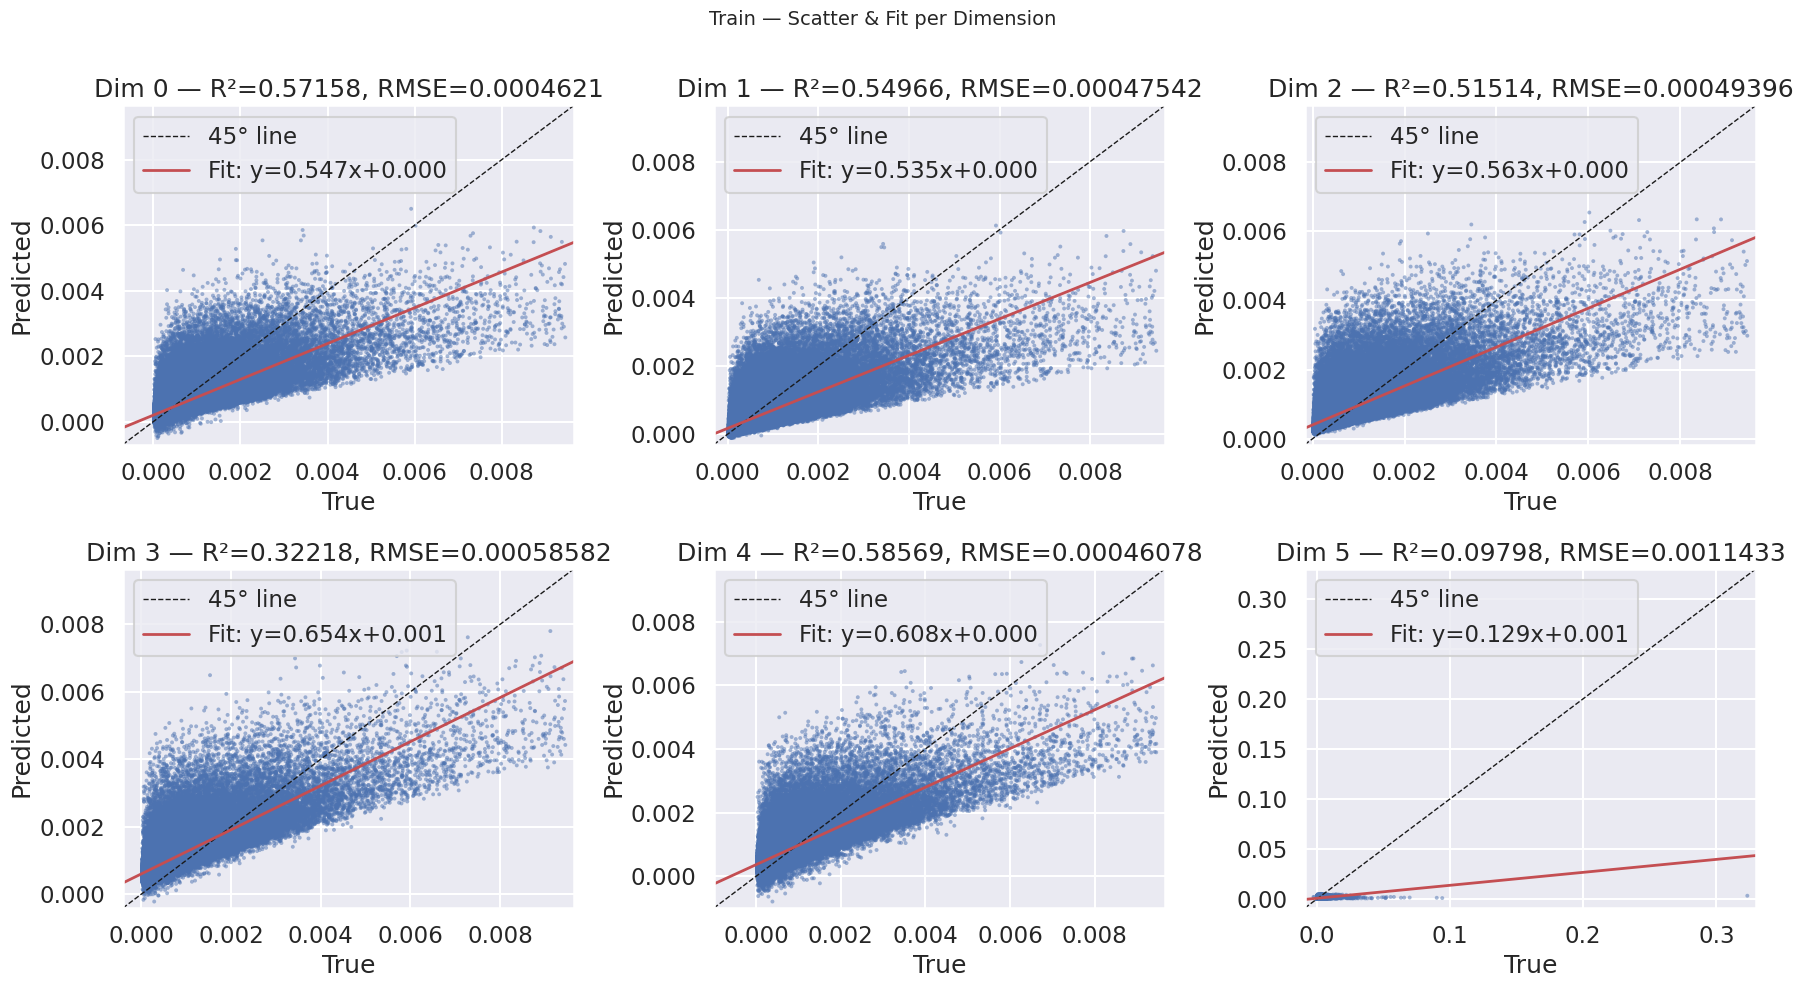

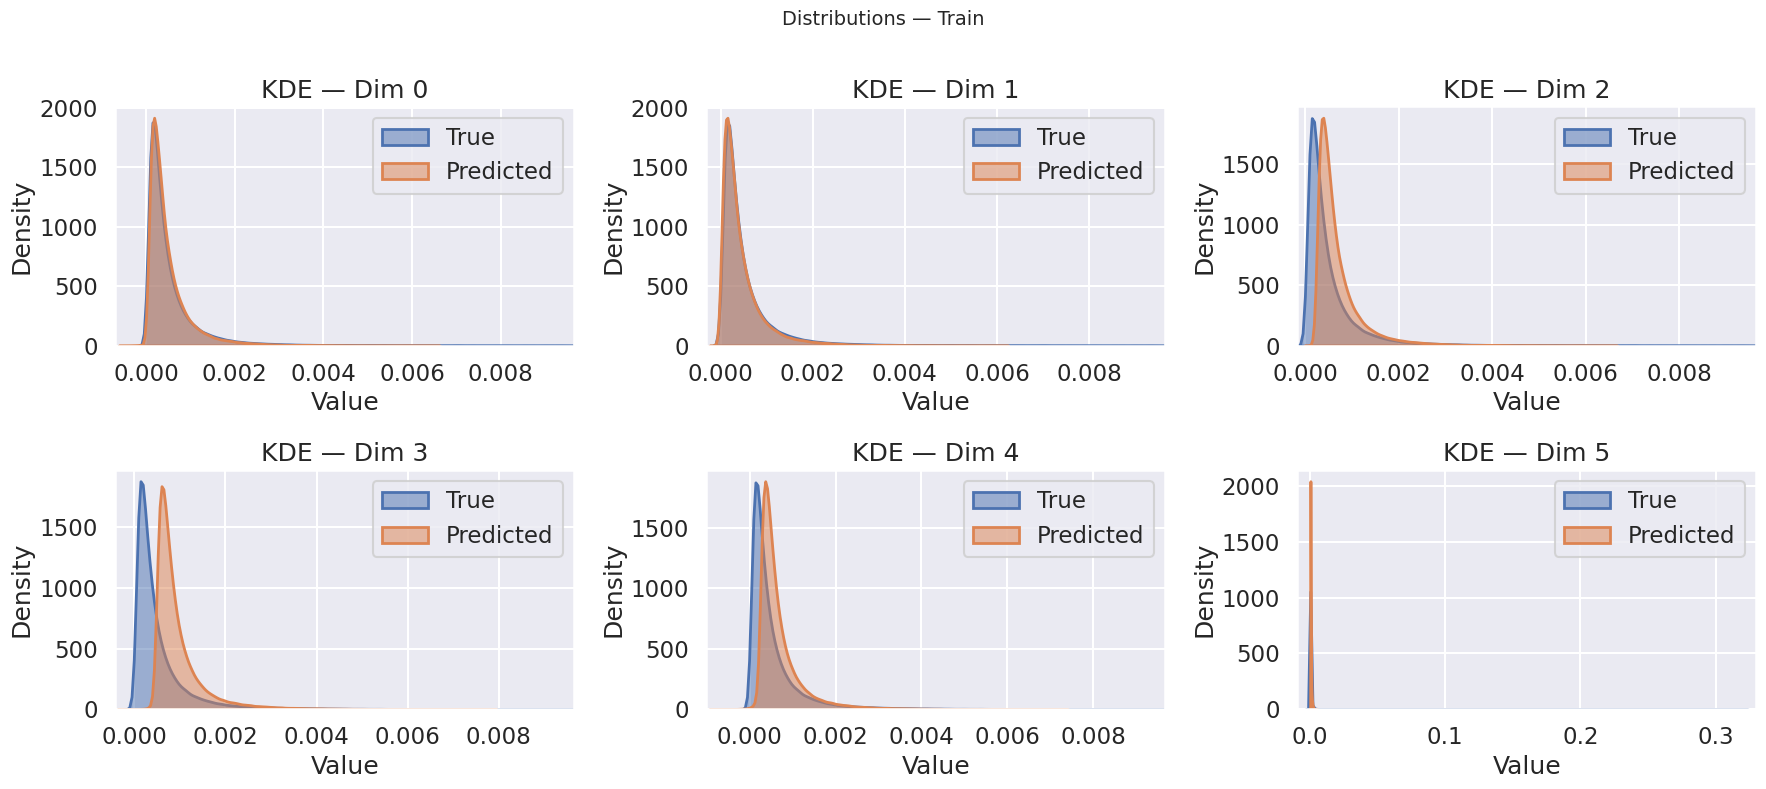

percentage: 56.5862
percentage: 68.7681
percentage: 12.7645
percentage: 3.5473
percentage: 12.8541
percentage: 10.6040


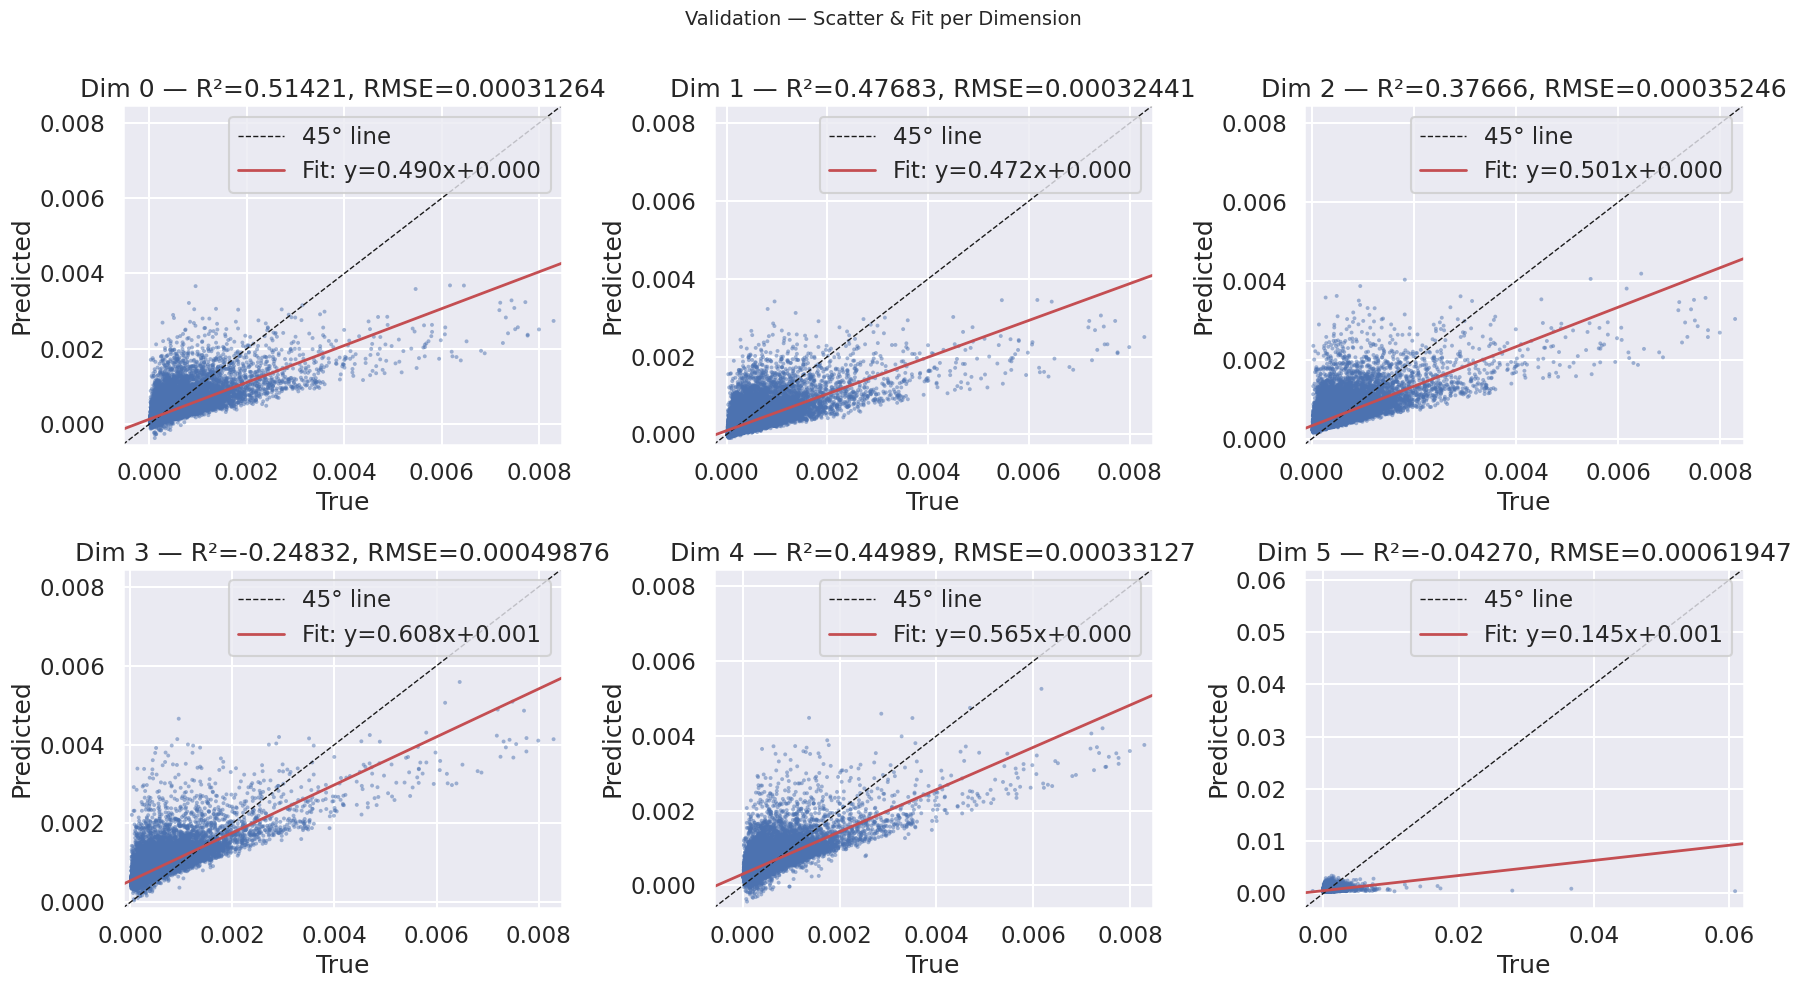

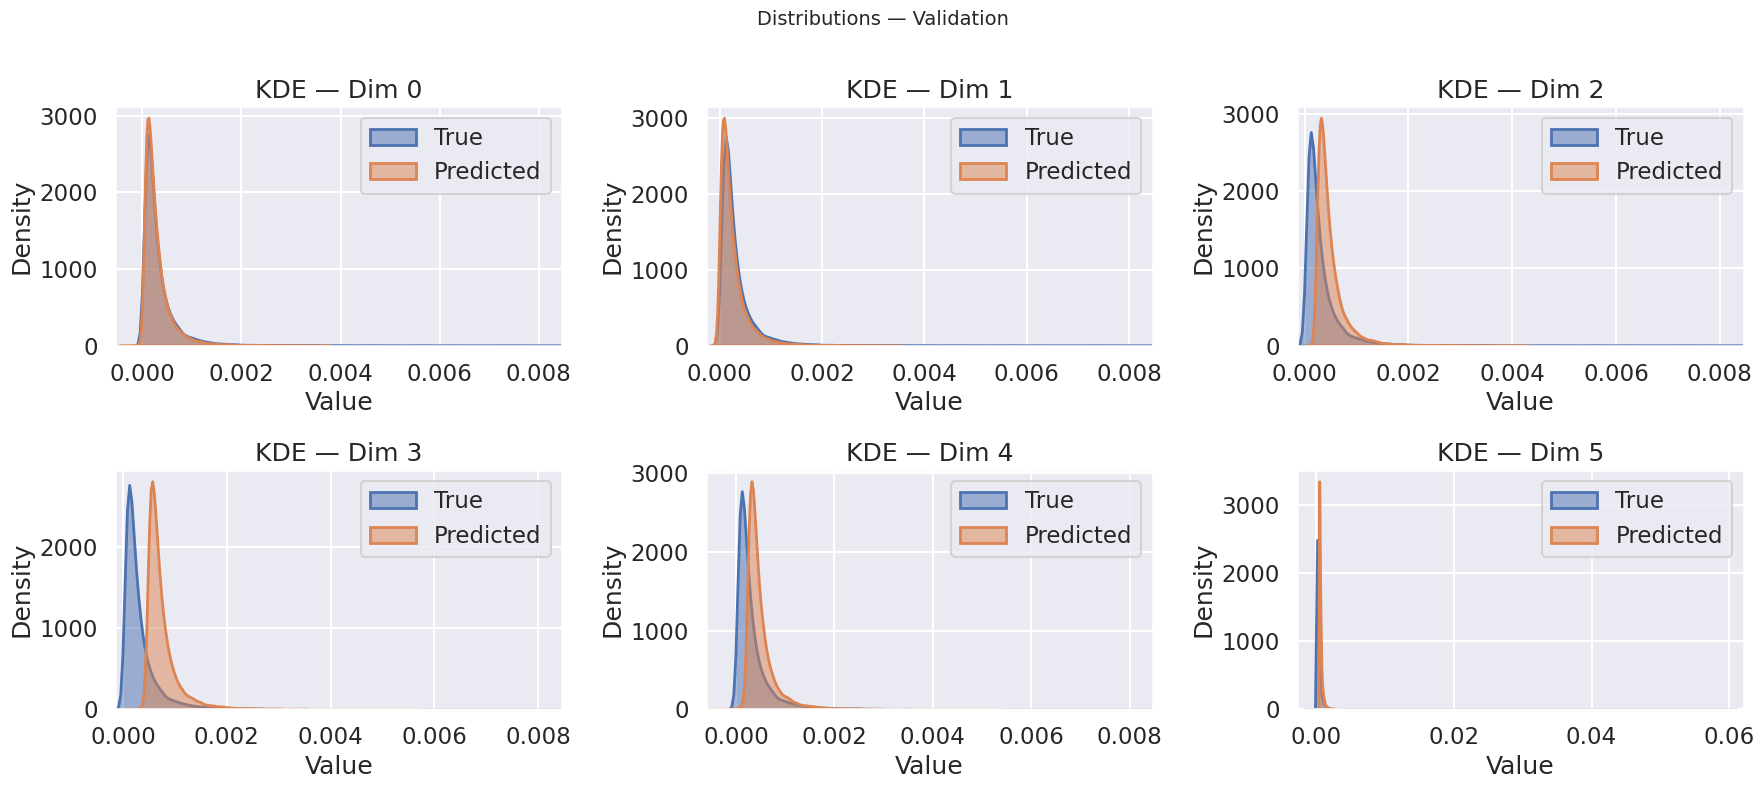

percentage: 56.6198
percentage: 69.7666
percentage: 11.5358
percentage: 2.8783
percentage: 11.4228
percentage: 9.4504


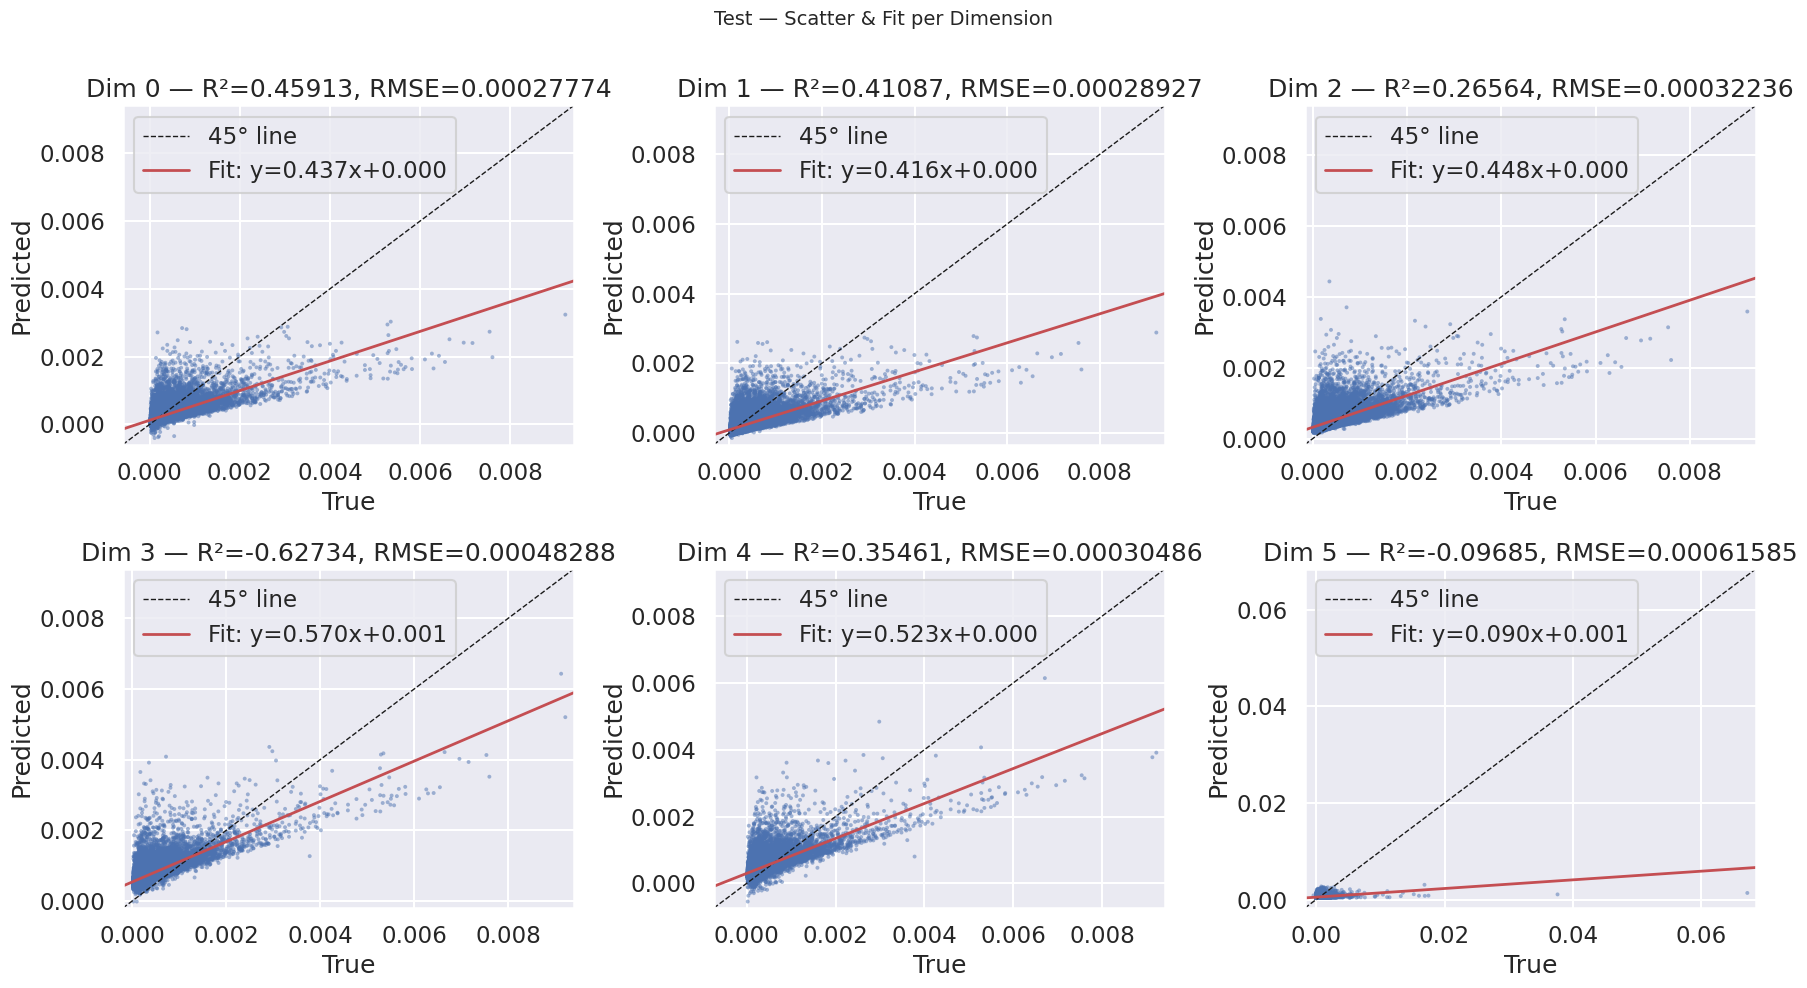

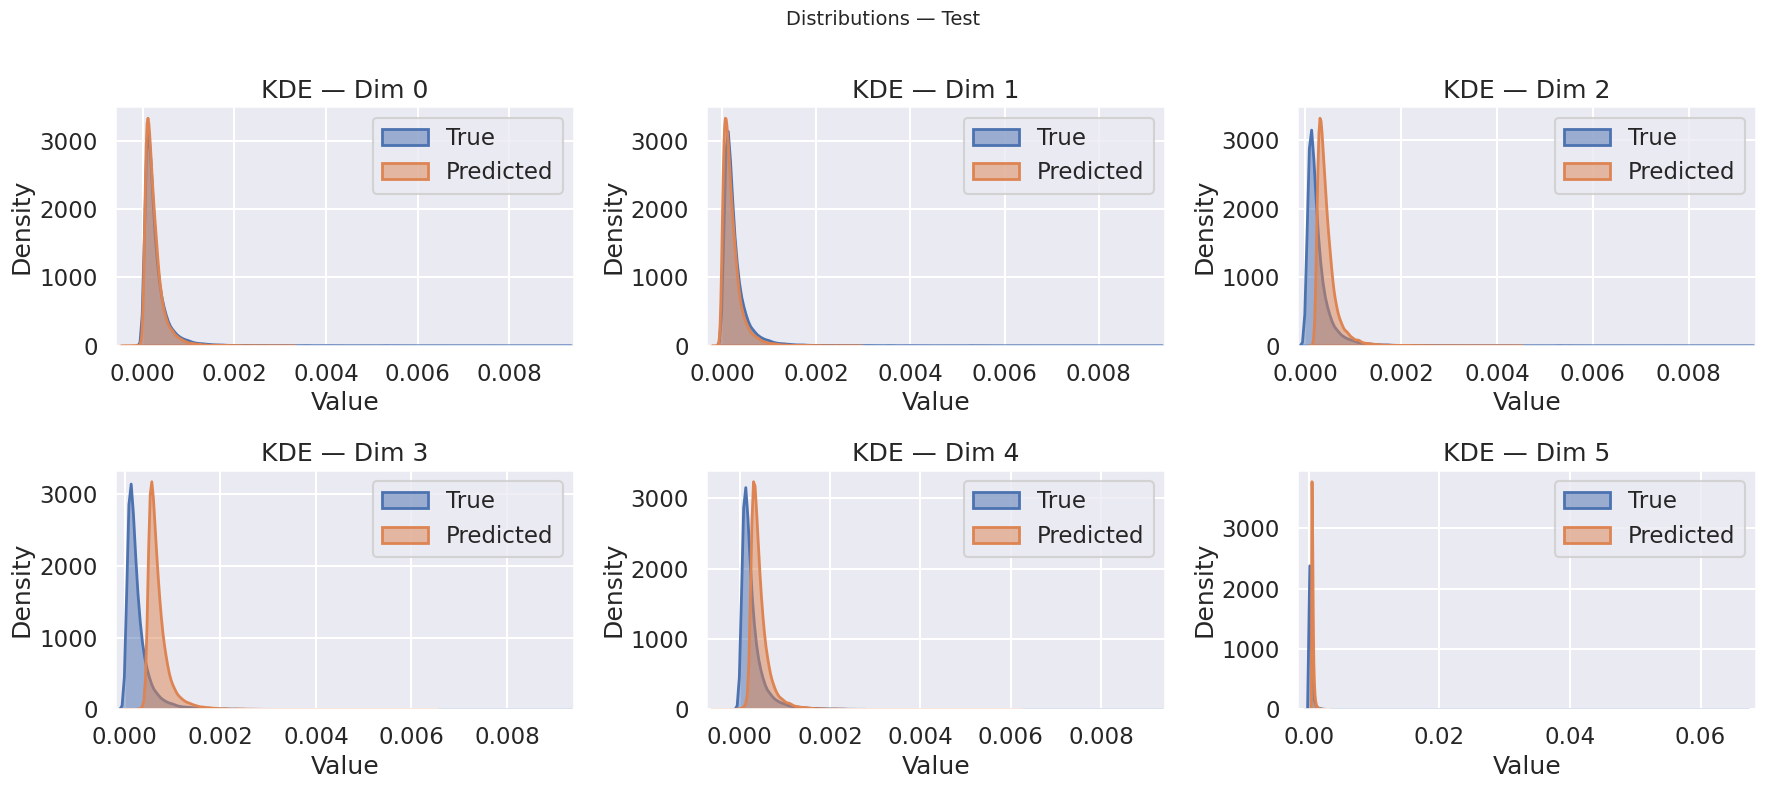

In [9]:
# old lines (now simplified)
model, trdata, vdata, tedata = eval_and_plot_simple(
    cfg,
    input_shape=None,         # you can even pass None now — it’s inferred
    output_shape=None,        # optional, inferred if missing
    ckpt=checkpoint,
    datasets=data[fold_num],
    device="cuda"
)


In [10]:
for fold in range(21):
    print("-"*50)
    print(f'fold: {fold}')
    for arr in data[fold]:
        print(f"{np.mean(arr):.4f}, {np.std(arr):.4f}, {np.percentile(arr, q=[0.05, 0.25, 0.5, 0.75, 0.95])},{np.min(arr):.4f}, {np.max(arr):.4f}")

--------------------------------------------------
fold: 0
0.0006, 0.0007, [2.06781752e-05 2.57287113e-05 3.03145307e-05 3.41817131e-05
 3.67988990e-05],0.0000, 0.0095
0.0005, 0.0008, [1.95338692e-05 2.41318323e-05 2.84548854e-05 3.19650969e-05
 3.44773357e-05],-0.0026, 0.3232
0.0003, 0.0005, [1.98854399e-05 2.30115956e-05 2.53688753e-05 2.74350577e-05
 2.90234109e-05],0.0000, 0.0094
0.0003, 0.0005, [1.75417081e-05 2.17444014e-05 2.42578442e-05 2.60638754e-05
 2.73321444e-05],-0.0015, 0.0608
0.0003, 0.0004, [1.96737553e-05 2.18442086e-05 2.39355248e-05 2.58125369e-05
 2.71364440e-05],0.0000, 0.0093
0.0003, 0.0004, [1.70134219e-05 2.09831884e-05 2.30890464e-05 2.47694584e-05
 2.61291600e-05],-0.0004, 0.0671
--------------------------------------------------
fold: 1


KeyError: 1

In [ ]:
y, yhat = trdata
np.mean(y - yhat)

np.float32(0.001966316)

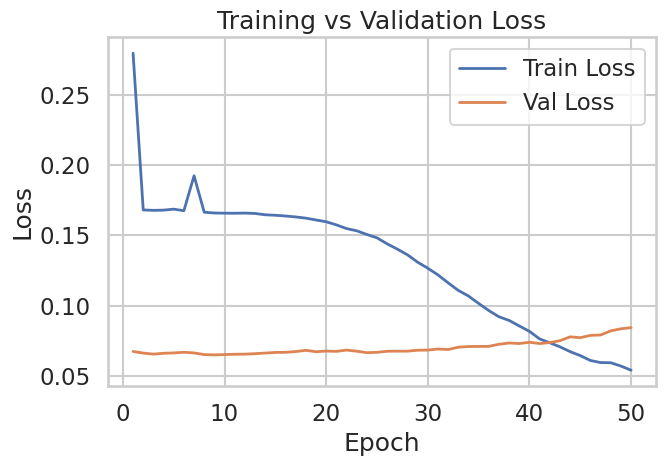

In [ ]:
def plot_training_history(ckpt):
    """Plot train vs validation loss curves from the saved checkpoint."""
    history = ckpt.get("history", None)
    if not history:
        print("No training history found in checkpoint.")
        return

    # Convert list of dicts to separate arrays
    tr_losses = [h["tr_loss"] for h in history]
    val_losses = [h["val_loss"] for h in history]
    epochs = np.arange(1, len(tr_losses) + 1)

    sns.set_theme(style="whitegrid", context="talk")
    plt.figure(figsize=(7,5))
    plt.plot(epochs, tr_losses, label="Train Loss", lw=2)
    plt.plot(epochs, val_losses, label="Val Loss", lw=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_training_history(checkpoint)

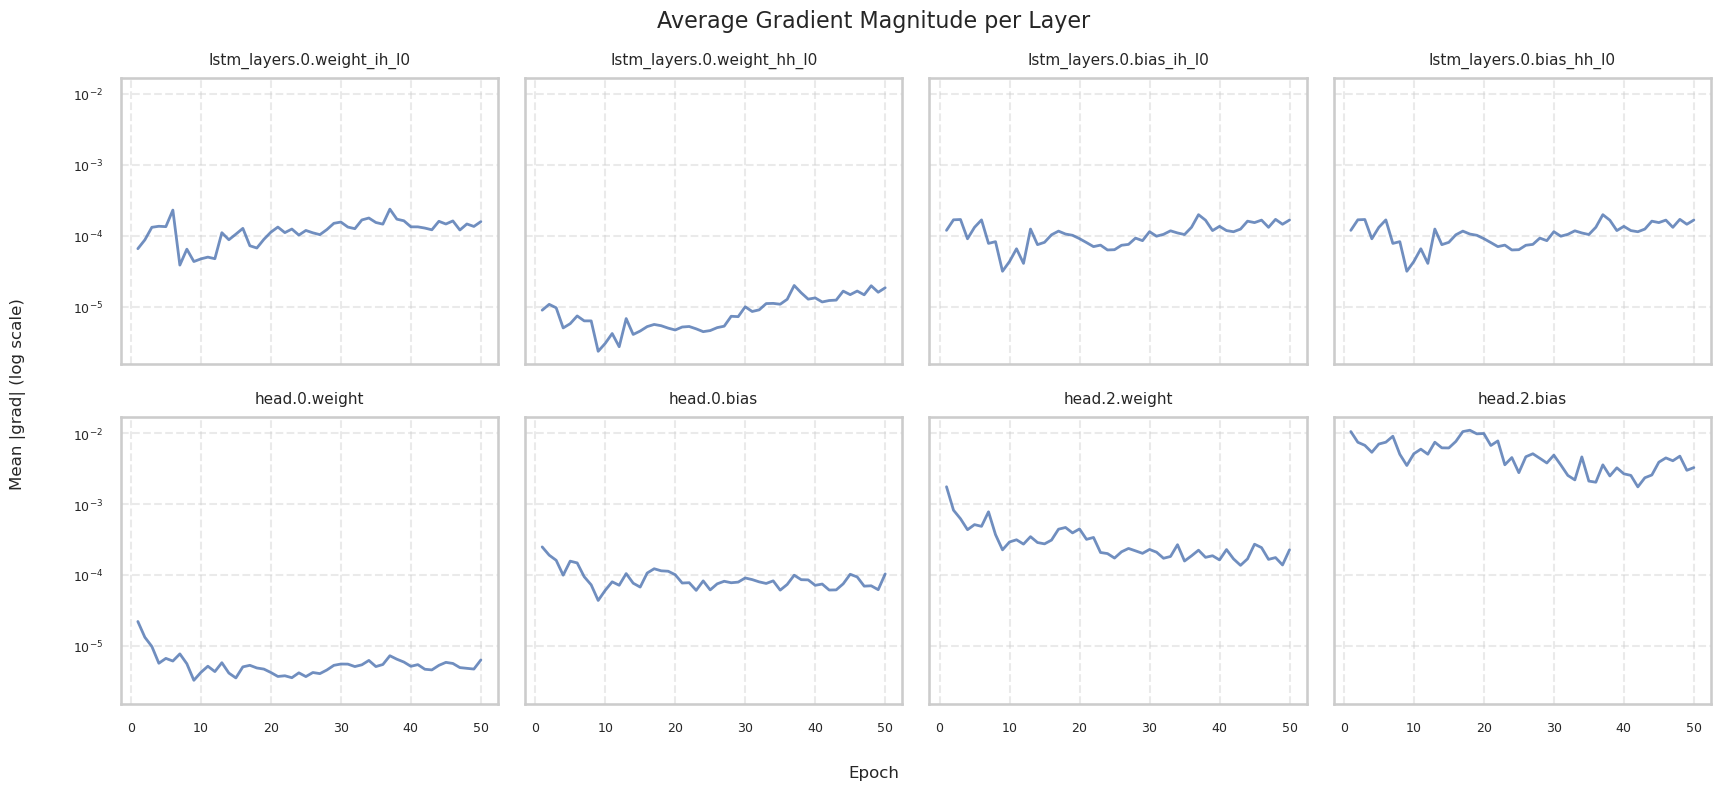

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import math

def plot_grad(ckpt):
    grad_history = ckpt.get("grad_history", [])
    if not grad_history:
        print("No grad_history found in checkpoint.")
        return

    df = pd.DataFrame(grad_history)
    if "epoch" not in df.columns:
        print("No 'epoch' column found in grad_history.")
        return

    df.set_index("epoch", inplace=True)
    
    # Clean column names for display (remove prefixes like _orig_mod.)
    df.columns = [c.replace("_orig_mod.", "") for c in df.columns]

    # --- grid setup ---
    n_cols = 4
    n_layers = len(df.columns)
    n_rows = math.ceil(n_layers / n_cols)

    # Increase figure size and adjust spacing
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, col in enumerate(df.columns):
        ax = axes[i]
        ax.plot(df.index, df[col], lw=2, alpha=0.8)
        ax.set_title(col, fontsize=11, pad=10)
        ax.set_yscale("log")
        ax.grid(True, linestyle="--", alpha=0.4)
        
        # Improve tick label formatting
        ax.tick_params(axis='both', which='major', labelsize=9)
        ax.tick_params(axis='both', which='minor', labelsize=7)
    
    # Hide empty tiles if #layers < grid size
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout with more padding
    plt.tight_layout(rect=[0.04, 0.04, 0.98, 0.96])  # [left, bottom, right, top]
    
    # Add titles with proper positioning
    fig.suptitle("Average Gradient Magnitude per Layer", fontsize=16, y=0.98)
    fig.text(0.5, 0.02, "Epoch", ha="center", fontsize=12)
    fig.text(0.02, 0.5, "Mean |grad| (log scale)", va="center", rotation="vertical", fontsize=12)
    
    plt.show()

plot_grad(checkpoint)

In [ ]:
ckpt = checkpoint
grad_history = ckpt.get("grad_history", [])

df = pd.DataFrame(grad_history)

df.set_index("epoch", inplace=True)

# Clean column names for display (remove prefixes like _orig_mod.)
df.columns = [c.replace("_orig_mod.", "") for c in df.columns]
df


,lstm_layers.0.weight_ih_l0,lstm_layers.0.weight_hh_l0,lstm_layers.0.bias_ih_l0,lstm_layers.0.bias_hh_l0,head.0.weight,head.0.bias,head.2.weight,head.2.bias
epoch,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.087891
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.088867
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.088867
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.089355
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.089355
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.089355
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.089355
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.089355
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.089355
